<a href="https://colab.research.google.com/github/Omarelsaadany/accidents_prediction/blob/main/accidents_prediction_DPS_CHALLENGE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

Read the data set

In [53]:
url = 'https://opendata.muenchen.de/dataset/5e73a82b-7cfb-40cc-9b30-45fe5a3fa24e/resource/40094bd6-f82d-4979-949b-26c8dc00b9a7/download/220511_monatszahlenmonatszahlen2204_verkehrsunfaelle.csv'



data_set1 = pd.read_csv(url)


Take only the first 5 columns and drop the rest.
Remove space from columns names.

In [54]:
data_set2 = data_set1.drop(['VORJAHRESWERT', 'VERAEND_VORMONAT_PROZENT','VERAEND_VORJAHRESMONAT_PROZENT','ZWOELF_MONATE_MITTELWERT'], axis=1)

data_set2.rename(columns=lambda x:x.replace(' ','_').lower(), inplace=True)


Drop the rows of years(2021,2022).


In [55]:

ds = data_set2.drop(data_set2[data_set2.jahr.isin([2021,2022])].index).reset_index(drop=True)

ds = ds.drop(ds[ds.monat.isin(['Summe'])].index).reset_index(drop=True)


ds.head()


,monatszahl,auspraegung,jahr,monat,wert
0,Alkoholunfälle,insgesamt,2020,202001,28.0
1,Alkoholunfälle,insgesamt,2020,202002,40.0
2,Alkoholunfälle,insgesamt,2020,202003,27.0
3,Alkoholunfälle,insgesamt,2020,202004,26.0
4,Alkoholunfälle,insgesamt,2020,202005,40.0


Remove the year and keeponly month in month column.

In [56]:
ds['monat'] = ds['monat'].str[4:]
ds = ds.astype({'monat':'int'})


Make sure no missing values

In [57]:
ds.info()
ds.isna().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1764 entries, 0 to 1763
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   monatszahl   1764 non-null   object 
 1   auspraegung  1764 non-null   object 
 2   jahr         1764 non-null   int64  
 3   monat        1764 non-null   int64  
 4   wert         1764 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 69.0+ KB


monatszahl     0
auspraegung    0
jahr           0
monat          0
wert           0
dtype: int64

Show statistical summary of all the quantitative variables

In [58]:
ds.describe()

,jahr,monat,wert
count,1764.000000,1764.000000,1764.000000
mean,2010.000000,6.500000,780.292517
std,6.057018,3.453031,1180.838117
min,2000.000000,1.000000,0.000000
25%,2005.000000,3.750000,38.750000
50%,2010.000000,6.500000,360.000000
75%,2015.000000,9.250000,813.250000
max,2020.000000,12.000000,4763.000000


Calculate the number of accidents per category.

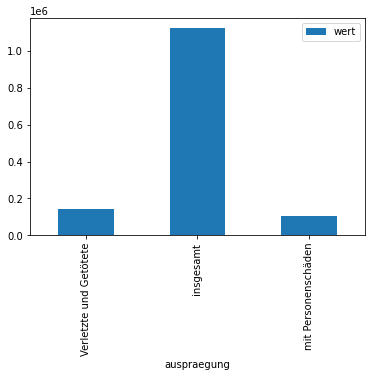

In [59]:
df_grouped = ds.groupby(by="auspraegung")["wert"].sum().plot(kind='bar',legend=True)

df_grouped

Calculate the number of categorize. 

In [60]:
obj = (ds.dtypes == 'object')
object_cols = list(obj[obj].index)
print("Categorical variables:",len(object_cols))
 


Categorical variables: 2


Analyze the different categorical features.

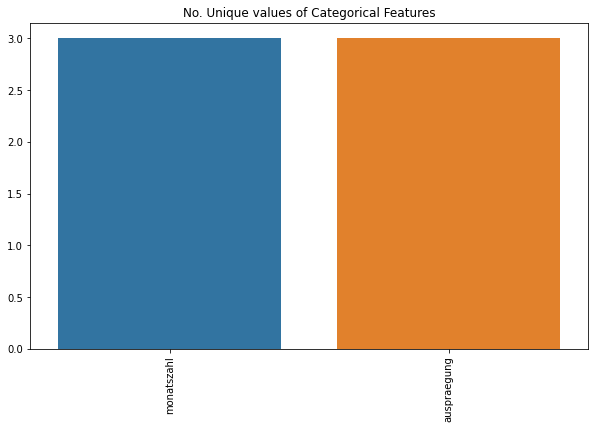

In [61]:

unique_values = []
for col in object_cols:
  unique_values.append(ds[col].unique().size)
plt.figure(figsize=(10,6))
plt.title('No. Unique values of Categorical Features')
plt.xticks(rotation=90)
sns.barplot(x=object_cols,y=unique_values)

OneHotEncoder :
firstly collect all the features which have the object datatype.


In [62]:

 
s = (ds.dtypes == 'object')
object_cols = list(s[s].index)
print("Categorical variables:")
print(object_cols)
print('No. of. categorical features: ',
      len(object_cols))

Categorical variables:
['monatszahl', 'auspraegung']
No. of. categorical features:  2


 once we have a list of all the features. We can apply OneHotEncoding to the whole list.

In [63]:
OH_encoder = OneHotEncoder(sparse=False)
OH_cols = pd.DataFrame(OH_encoder.fit_transform(ds[object_cols]))
OH_cols.index = ds.index
OH_cols.columns = OH_encoder.get_feature_names()
df = ds.drop(object_cols, axis=1)
df = pd.concat([df, OH_cols], axis=1)
df

,jahr,monat,wert,x0_Alkoholunfälle,x0_Fluchtunfälle,x0_Verkehrsunfälle,x1_Verletzte und Getötete,x1_insgesamt,x1_mit Personenschäden
0,2020,1,28.0,1.0,0.0,0.0,0.0,1.0,0.0
1,2020,2,40.0,1.0,0.0,0.0,0.0,1.0,0.0
2,2020,3,27.0,1.0,0.0,0.0,0.0,1.0,0.0
3,2020,4,26.0,1.0,0.0,0.0,0.0,1.0,0.0
4,2020,5,40.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
1759,2000,8,647.0,0.0,0.0,1.0,1.0,0.0,0.0
1760,2000,9,675.0,0.0,0.0,1.0,1.0,0.0,0.0
1761,2000,10,615.0,0.0,0.0,1.0,1.0,0.0,0.0
1762,2000,11,578.0,0.0,0.0,1.0,1.0,0.0,0.0


Splitting Dataset into Training and Testing.

In [64]:


X = df.drop(['wert'], axis=1)
Y = df['wert']

# Split the training set into
# training and validation set
X_train, X_test, Y_train, Y_test = train_test_split(
	X, Y, train_size=0.8, test_size=0.2, random_state=0)
X_test
Y_test

1165    2643.0
668      797.0
412       39.0
558     1095.0
1234    3529.0
         ...  
1044    3320.0
970       59.0
539      900.0
1597     326.0
1052    4017.0
Name: wert, Length: 353, dtype: float64

I wil train the model to determine the continuous values, I will be using these regression model of Random Forest Regressor.

Random Forest is an ensemble technique that uses multiple of decision trees .

In [65]:

 
model_RFR = RandomForestRegressor(n_estimators=10)
model_RFR.fit(X_train, Y_train)
Y_pred = model_RFR.predict(X_test)
 
mean_absolute_percentage_error(Y_test, Y_pred)


0.14048186855024278

Forecasts the values for:

Category: 'Alkoholunfälle'

Type: 'insgesamt

Year: '2021'

Month: '01'

In [66]:
test_set = pd.read_csv(url)
test_set = test_set.drop(['VORJAHRESWERT', 'VERAEND_VORMONAT_PROZENT','VERAEND_VORJAHRESMONAT_PROZENT','ZWOELF_MONATE_MITTELWERT'], axis=1)

test_set.rename(columns=lambda x:x.replace(' ','_').lower(), inplace=True)
test_set = test_set.drop(test_set[test_set.monat.isin(['Summe'])].index).reset_index(drop=True)
test_set['monat'] = test_set['monat'].str[4:]
test_set = test_set.astype({'monat':'int'})
test_set

,monatszahl,auspraegung,jahr,monat,wert
0,Alkoholunfälle,insgesamt,2022,1,NaN
1,Alkoholunfälle,insgesamt,2022,2,NaN
2,Alkoholunfälle,insgesamt,2022,3,NaN
3,Alkoholunfälle,insgesamt,2022,4,NaN
4,Alkoholunfälle,insgesamt,2022,5,NaN
...,...,...,...,...,...
1927,Verkehrsunfälle,Verletzte und Getötete,2000,8,647.0
1928,Verkehrsunfälle,Verletzte und Getötete,2000,9,675.0
1929,Verkehrsunfälle,Verletzte und Getötete,2000,10,615.0
1930,Verkehrsunfälle,Verletzte und Getötete,2000,11,578.0


In [67]:
s = (test_set.dtypes == 'object')
object_cols = list(s[s].index)
print("Categorical variables:")
print(object_cols)
print('No. of. categorical features: ',
      len(object_cols))



Categorical variables:
['monatszahl', 'auspraegung']
No. of. categorical features:  2


In [68]:
OH_encoder = OneHotEncoder(sparse=False)
OH_cols = pd.DataFrame(OH_encoder.fit_transform(test_set[object_cols]))
OH_cols.index = test_set.index
OH_cols.columns = OH_encoder.get_feature_names()
test_set = test_set.drop(object_cols, axis=1)
test_set = pd.concat([test_set, OH_cols], axis=1)
test_set

,jahr,monat,wert,x0_Alkoholunfälle,x0_Fluchtunfälle,x0_Verkehrsunfälle,x1_Verletzte und Getötete,x1_insgesamt,x1_mit Personenschäden
0,2022,1,NaN,1.0,0.0,0.0,0.0,1.0,0.0
1,2022,2,NaN,1.0,0.0,0.0,0.0,1.0,0.0
2,2022,3,NaN,1.0,0.0,0.0,0.0,1.0,0.0
3,2022,4,NaN,1.0,0.0,0.0,0.0,1.0,0.0
4,2022,5,NaN,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
1927,2000,8,647.0,0.0,0.0,1.0,1.0,0.0,0.0
1928,2000,9,675.0,0.0,0.0,1.0,1.0,0.0,0.0
1929,2000,10,615.0,0.0,0.0,1.0,1.0,0.0,0.0
1930,2000,11,578.0,0.0,0.0,1.0,1.0,0.0,0.0


Extract the year of 2021 which we want to predict.

In [75]:
X_test1=test_set.iloc[12:24].drop(['wert'], axis=1)
 
Y_test1 = test_set['wert'].iloc[12:24]
X_test1


,jahr,monat,x0_Alkoholunfälle,x0_Fluchtunfälle,x0_Verkehrsunfälle,x1_Verletzte und Getötete,x1_insgesamt,x1_mit Personenschäden
12,2021,1,1.0,0.0,0.0,0.0,1.0,0.0
13,2021,2,1.0,0.0,0.0,0.0,1.0,0.0
14,2021,3,1.0,0.0,0.0,0.0,1.0,0.0
15,2021,4,1.0,0.0,0.0,0.0,1.0,0.0
16,2021,5,1.0,0.0,0.0,0.0,1.0,0.0
17,2021,6,1.0,0.0,0.0,0.0,1.0,0.0
18,2021,7,1.0,0.0,0.0,0.0,1.0,0.0
19,2021,8,1.0,0.0,0.0,0.0,1.0,0.0
20,2021,9,1.0,0.0,0.0,0.0,1.0,0.0
21,2021,10,1.0,0.0,0.0,0.0,1.0,0.0


In [70]:
Y_test1

12    16.0
13    14.0
14    24.0
15    16.0
16    24.0
17    48.0
18    44.0
19    46.0
20    54.0
21    43.0
22    33.0
23    21.0
Name: wert, dtype: float64

Make the prediction for year of 2021.

In [72]:
Y_pred = model_RFR.predict(X_test1)
 
mean_absolute_percentage_error(Y_test1, Y_pred)
Y_pred

array([28. , 35.9, 28.7, 28. , 36.9, 41.5, 47.6, 41.4, 44.2, 26.4, 22. ,
       15. ])

The predicted (wert) is 28